In [1]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation_vi import run_HD as run_DCODE

from toolbox.auxiliary_functions import set_param_freq, intercept_library_fun

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
# z = np.load("latent_data.npy")
# z_reshaped = z[np.newaxis, :300, :]
# print(z_reshaped.shape)

import numpy as np

z = np.load("latent_data.npy")  # shape: (1000, 2)

# reshape in (10, 100, 2)
z_reshaped = z.reshape(2, 500, 2)

print(z_reshaped.shape)


(2, 500, 2)


In [3]:
# Select ODE & settings:
ode_name = 'ReactionDiffusion' # help="name of the ode", type=str
ode_param = '1,1' # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 20 # help="sampling frequency", type=float, default=10
n_sample = 1 # help="number of trajectories", type=int, default=100
noise_ratio = 0.0 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0

T0 = 0
T = (z_reshaped.shape[1] - 1)/freq

latent_data = z_reshaped.transpose(1, 0, 2)

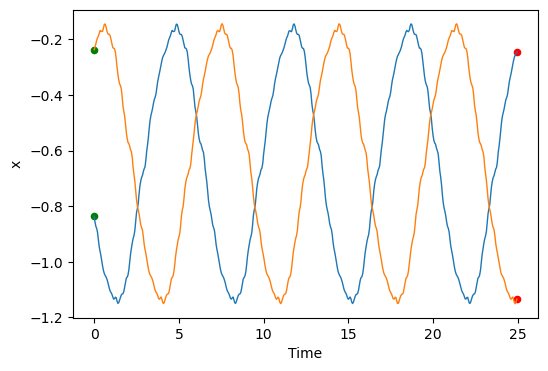

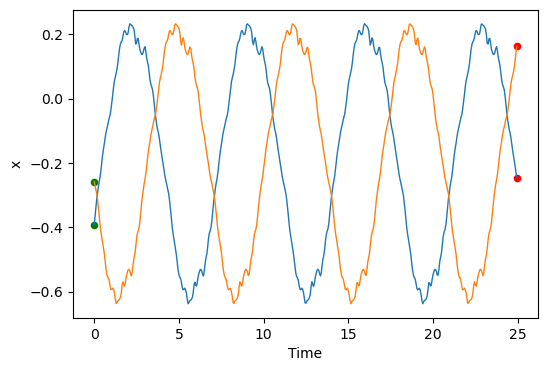

In [4]:
SINDy_data.plot_configuration(np.array(z_reshaped)[:,:,0:1], T)
SINDy_data.plot_configuration(np.array(z_reshaped)[:,:,1:2], T)

Dataset shape:  (500, 2, 2)
[-0.8363022  -0.85739654 -0.87271583 -0.8801824  -0.89538044 -0.9227936
 -0.94679266 -0.9621741  -0.97836584 -0.9979988  -1.0162992  -1.0318295
 -1.0426841  -1.0492667  -1.0543444  -1.0619065  -1.0720208  -1.0842668
 -1.0970982  -1.1061462 ]


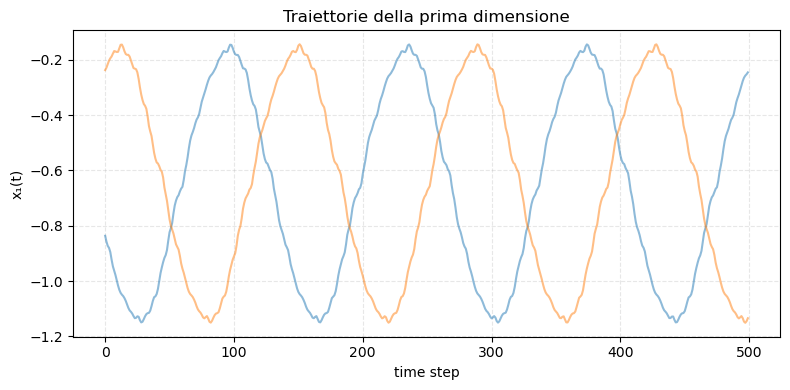

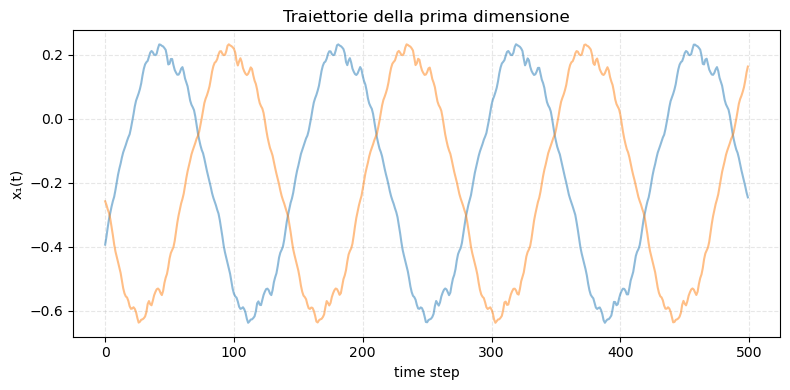

Functions set:  {'add': 1, 'mul': 1, 'sub': 1, 'neg': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.36          9722.59       15          9.14136          8.08518     43.80s
   1    10.12          487.849       15          8.08518          9.14136     30.53s
   2    10.13          389.423       17          4.00658          3.93409     23.47s
 
promising programs:
add(neg(sin(sin(sin(4.142)))), sin(neg(sub(mul(X0, mul(1.894, X1)), add(X1, X0)))))
add(neg(sin(sin(sin(4.142)))), sin(neg(sub(mul(X0, mul(1.894, X1)), add(X1, X0)))))
add(neg(sin(sin(sin(4.142)))), sin(neg(sub(mul(X0, mul(1.894, X1)), add(X1, X0)))))
add(neg(sin(sin(sin(4.142)))), sin(neg(sub(mul(X0, mul(1.894, X1)), add(X1, X0)))))
add(neg(sin(sin(sin(4.142)))), sin(neg(sub(mul(X0, mul(1.894, X1)), add(X

In [5]:
# additional building blocks -> running D-CODE:
building_blocks_lambda, function_names = run_DCODE(ode_name=ode_name, ode_param=ode_param, x_id=x_id,
                                                   freq=freq, n_sample=n_sample, noise_ratio=noise_ratio, 
                                                   seed=seed, n_seed=n_seed, T0=T0, T=T, 
                                                   latent_data=latent_data)

In [6]:
degree = 2
threshold = 0.4
penalty = 100

# generate data to run SINDy:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data_HD(ode_name=ode_name, ode_param=ode_param, 
                                                                      freq=freq, n_sample=n_sample, 
                                                                      noise_ratio=noise_ratio, dim_x=dim_x, dim_k=dim_k,
                                                                      T0=T0, T=T, latent_data = latent_data)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(2, 499, 2) (2, 499, 2) (0,)
['X0', 'X1']


In [7]:
print('Searching for the best building block:')

errors = []
n_features_vec = []
intercept_library = intercept_library_fun(dim_x+dim_k) # intercept library
polynomial_library = ps.PolynomialLibrary(degree=degree, include_bias=False) # polynomial library

for i in range(len(building_blocks_lambda)):

    # building the library:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]]) # custom library with building block
    generalized_library = ps.GeneralizedLibrary(libraries=[polynomial_library, custom_library],tensor_array=[[1, 1]])
    final_library = ps.ConcatLibrary([intercept_library, generalized_library]) # add the intercept

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=threshold))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    print('Model:')
    model.print()   

    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)
    # print()   

    # evaluate the model:  
    coefficients = model.coefficients()
    model_complexity = np.count_nonzero(np.array(model.coefficients()))
    lasso_penalty = np.sum(np.abs(coefficients))
    if model_complexity < penalty and lasso_penalty < penalty: #filter too complex models (for sure not correct and likely to crash the code):
        _, mse = SINDy_data.evaluate_RMSE_HD(model=model, latent_data=X_list, freq=10, n_sample=2, T0=T0, T=T, dim_k=dim_k) # compute MSE      
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty # final evaluation metric
        # print('error:', error)
    else:
        error = 1000
        #print('Too complex model')
    #print('')
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))

print("errors: ", errors)
if all(err == 1000 for err in errors):
    print('No model update, all smart-SINDy models are too complex')

else:
    # Final model
    min_error = min(errors)
    idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
    n_features_vec_2 = [n_features_vec[i] for i in idxs]

    if len(idxs) > 1:
        # print('Multiple models with similar error, selecting the simplest one with the lowest error')
        # print('')
        min_features = min(n_features_vec_2) # find the min number of features among the candidates
        idxs_min_feat = [idxs[i] for i, nf in enumerate(n_features_vec_2) if nf == min_features] # select al the indexes with that number of features
        idx = idxs_min_feat[np.argmin([errors[i] for i in idxs_min_feat])] # among these, choose the one with less error
    else:
        idx = idxs[0]

    # building the library:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])  # custom library with building block
    model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    building_block = custom_library.get_feature_names(input_features=feature_names) 
    generalized_library = ps.GeneralizedLibrary(libraries=[polynomial_library, custom_library],tensor_array=[[1, 1]])
    final_library = ps.ConcatLibrary([intercept_library, generalized_library]) # add the intercept

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=threshold))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    # best building block:
    print('')
    print('Best building block:')
    print(building_block)
    print('')

    # final model:
    print('Smart-SINDy model:')
    model.print()

Searching for the best building block:
Model:
(X0)' = -1.474 X0 X1 + -0.870 X0 X1 sin(X1) + 0.524 X1^2 sin(X1)
(X1)' = -0.676 1 + -0.884 X0 + 0.752 X0 sin(X1) + -1.228 X1^2 sin(X1)
Model:
(X0)' = -1.382 X0 + -1.300 X0 X1 + -1.687 X1^2 + 0.941 X1 -sin(sin(X1) + 1.3838127353883953) + 1.353 X0^2 -sin(sin(X1) + 1.3838127353883953) + 1.480 X0 X1 -sin(sin(X1) + 1.3838127353883953)
(X1)' = -0.713 1 + -1.467 X1 + 0.721 X0 X1 + 1.795 X1^2 + 0.975 X0 -sin(sin(X1) + 1.3838127353883953) + -1.172 X1 -sin(sin(X1) + 1.3838127353883953) + 2.534 X1^2 -sin(sin(X1) + 1.3838127353883953)
Model:
(X0)' = -1.749 X0 X1 + -2.541 X1^2 + 0.487 X1 sin(X1 + 4.123603725400237) + -5.960 X1^2 sin(X1 + 4.123603725400237)
(X1)' = -1.002 X0 + 0.953 sin(X1 + 4.123603725400237)
Model:
(X0)' = 1.466 X1 + -0.955 X0 X1 + -0.065 X1^2 + -0.566 sin(sin(X1 + 4.123603725400237)) + 1.515 X1 sin(sin(X1 + 4.123603725400237)) + 0.595 X0^2 sin(sin(X1 + 4.123603725400237)) + 0.275 X0 X1 sin(sin(X1 + 4.123603725400237)) + -1.969 X1^2 si